In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet('data/transfers_since_2013.parquet')

In [3]:
# new column: Property Class as integer
df['PropClass'] = pd.to_numeric(df['Class_desc'].str[:3], errors='coerce')

In [4]:
# filter to SFH only
# 43081 out of 55053 transfers were single-family homes
df = df.loc[df['PropClass'].isin([101,110,115,120,130,150])]

# Remove some specific outliers that are not really SFH
df = df.loc[~df['Parcel_ID'].str.strip().isin(['S0002610015','E0000884025','E0000429010','E0000378003'])]

In [192]:
# Fix Parcel_ID just in case
df['Parcel_ID'] = df['Parcel_ID'].str.strip()

We have a couple of markers for identifying flips vs. new housing:

If YrBuilt is <2 years before Transfer_date, it's new housing

If YrBuilt is NaN, it's probably a vacant lot

In [53]:
df

,Parcel_ID,Card,Class_desc,NBHDno,NBHDname,district_number,Prop_stree,Transfer_date,Consideration,Transfer_comment,...,Deed_page,Grantor,Grantee,Story,YearBlt,FinArea,TransferComment,YrBuilt,FinSize,PropClass
0,C0010124012,nan,101 Single Family Vacant (R1-R6),140.0,Traylor Estate/Huguenot Farms,4.0,8780 RIVERSIDE DR,2012-07-24,200000,Multi-Parcel Sale,...,14350,WILEY JOANN T,PRINCE J STEPHEN & ELIZABETH N,NaN,NaN,NaN,nan,NaN,NaN,101.0
1,C0010126020,R01,110 One Story,140.0,Traylor Estate/Huguenot Farms,4.0,8781 RIVERSIDE DR,2012-07-24,700000,Multi-Parcel Sale,...,14351,WILEY JOANN T,PRINCE J STEPHEN & ELIZABETH R,1.0,1930.0,2656.0,nan,NaN,NaN,110.0
2,C0010126026,R01,110 One Story,148.0,SouthHampton/Oxford,4.0,8646 RIVERCREST ROAD,2012-10-19,0,Related Parties,...,20843,CORKRAN LAVERN H,CORKRAN LAVERN H & DOUGLAS E,1.0,1956.0,2808.0,nan,NaN,NaN,110.0
3,C0010126028,R01,110 One Story,140.0,Traylor Estate/Huguenot Farms,4.0,8724 RIVERCREST ROAD,2012-07-24,200000,Multi-Parcel Sale,...,14350,WILEY JOANN T,PRINCE J STEPHEN & ELIZABETH R,1.0,1960.0,560.0,nan,NaN,NaN,110.0
4,C0010210022,R01,"115 One Story+ (1.25, 1.5, 1.75)",140.0,Traylor Estate/Huguenot Farms,4.0,8819 RIVERSIDE DR,2012-09-26,365333,Related Parties,...,19063,HORWITZ LOUIS H,HORWITZ TRACEY,1.5,1948.0,3685.0,nan,NaN,NaN,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55043,W0220162004,R01,120 Two Story,132.0,Ampthill/Hmptn Hlls/Hillcrest,106.0,7 River Road,2022-02-18,950000,nan,...,4215,BILLETT BETH,EBERHARDT WILLIAM,2.0,NaN,NaN,nan,1925.0,2934.0,120.0
55044,W0220162005,R01,120 Two Story,132.0,Ampthill/Hmptn Hlls/Hillcrest,106.0,9 River Road,2022-01-20,1725000,nan,...,1658,GIBSON PEARSON G,GATES RICHARD WILLIAMS AND,2.0,NaN,NaN,Asmnt/Sale Desc Doesn't Match,1937.0,3336.0,120.0
55050,W0220191007,R01,120 Two Story,136.0,Windsor Farms/Rothesay,106.0,206 Gun Club Road,2022-01-28,940000,nan,...,2425,KENNY ANNE W TRUSTEE,BROCK LESTER C III AND,2.0,NaN,NaN,Asmnt/Sale Desc Doesn't Match,1967.0,3341.0,120.0
55051,W0220222011,R01,120 Two Story,136.0,Windsor Farms/Rothesay,106.0,211 Berkshire Road,2022-01-04,1300000,nan,...,43,GLOSSOP SIMON G AND ELLA CARSON,ALAS KEVIN AND KELSEY B,1.0,NaN,NaN,nan,1951.0,3410.0,120.0


In [97]:
df['sale'] = df['Deed_book'] + '.' + df['Deed_page']
#pre-work: group by parcel_id (and sale) and only keep columns we need
preflips = df.groupby(['Parcel_ID','Grantor','Grantee','sale']).agg({'NBHDno':'min','district_number':'min',
                                      'Transfer_date':'min',
                                      'Consideration':'min',
                                      'TransferComment': ';'.join,
                                      'YrBuilt':'min',
                                      'FinSize':'sum'})

In [98]:
preflips.reset_index(inplace=True)

In [99]:
# identify parcels resold 
# I think a self-join makes the most sense
flips = preflips.merge\
    (preflips,left_on = ['Parcel_ID', 'Grantee'], right_on = ['Parcel_ID', 'Grantor'], how='inner')
flips.shape

(9706, 21)

In [100]:
# Add timedelta column for how long the property was held for
flips['hold_time'] = flips['Transfer_date_y'] - flips['Transfer_date_x']

<AxesSubplot:>

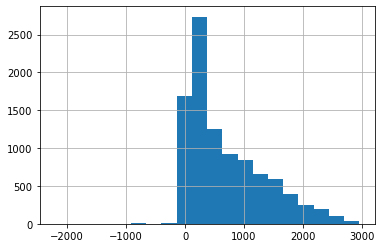

In [101]:
flips['hold_time'].dt.days.hist(bins=20)

In [102]:
# filter out:
# hold times < 0 - these are probably cycles (30 rows)
flips = flips.loc[flips['hold_time'].dt.days >= 0]
# hold times > 2 years - probably somebody just lived there and then moved (3719 rows)
flips = flips.loc[flips['hold_time'] < pd.Timedelta(365*2, "d")]
flips.shape

(6026, 22)

In [103]:
# add a column for price difference
flips['price_diff'] = flips['Consideration_y'] - flips['Consideration_x']

In [104]:
flips = flips.loc[flips['price_diff']>0] # exclude 1361 rows
# warning: some of the large negative price differences are due to the first sale being "multiple parcels"
# for our purposes, I don't think that's immediately relevant, since most flippers seem to buy houses individually.
flips.shape

(4677, 23)

In [105]:
# drop invalid sales
# how many are 'invalid sales'? about a quarter of the remaining rows - 1151 / 4742
# many of them are 
#flips.loc[flips['TransferComment_y'] != 'nan']
# exclude certain invalid sales - keep the rest for now
flips = flips.loc[~flips['TransferComment_y'].isin(['Foreclosure Related/Short Sale','Sale Includes Multiple Parcels','Special Financing/Terms, etc.'])]
flips.shape

(4407, 23)

In [145]:
# drop flips where the first sale was 0 sq ft - probably a vacant lot
flips = flips.loc[flips['FinSize_x']>0]
# also drop flips where a house was razed and a new one built (9 rows)
flips = flips.loc[flips['YrBuilt_x']<=flips['YrBuilt_y']]
# drop flips where the house is newly built (~400 rows)
flips['age'] = flips['year'] - flips['YrBuilt_y']
flips = flips.loc[flips['age']>=2]
flips.shape

(3669, 26)

In [183]:
# let's add the difference in sq.footage - a good sign of a serious renovation
flips['size_diff'] = flips['FinSize_y'] - flips['FinSize_x']
# also ROI
flips['roi'] = (flips['price_diff'] / flips['Consideration_x']) *100

In [146]:
#flips.shape
#flips.sort_values(['price_diff']).tail(20)

#
flips.loc[flips['Consideration_y']<500000].sort_values(['price_diff']).tail(10)

,Parcel_ID,Grantor_x,Grantee_x,sale_x,NBHDno_x,district_number_x,Transfer_date_x,Consideration_x,TransferComment_x,YrBuilt_x,...,Transfer_date_y,Consideration_y,TransferComment_y,YrBuilt_y,FinSize_y,hold_time,price_diff,size_diff,year,age
5659,N0001249025,MEADOWS PATRICIA A AND,KC ENTERPRISES OF VA LLC,ID2016.11192,209.0,303.0,2016-06-15,70000,"Foreclosure, Forced Sale etc.",1923.0,...,2017-12-18,429950,nan,1928.0,2278.0,551 days,359950,92.0,2017,89.0
6135,N0160133003,MCLEOD MARION JR,JORDAN ALPHONSO R,ID2017.16011.0,209.0,303.0,2017-08-02,12500,"Foreclosure, Forced Sale etc.",1950.0,...,2019-04-26,374950,nan,1950.0,2663.0,632 days,362450,1647.0,2019,69.0
2554,E0000431009,JOHNSON WILLIAM P & CARRIE H,MATTHEWS COREY,ID2020.2979,338.0,707.0,2020-02-10,35764,Asmnt/Sale Desc Doesn't Match,1910.0,...,2021-05-19,405000,nan,1910.0,2056.0,464 days,369236,0.0,2021,111.0
2408,E0000290004,GREEN CORLOUS AND LORIE,SOJO ENTERPRISES LLC,ID2018.2664,338.0,707.0,2018-02-09,80000,nan,1900.0,...,2019-06-26,450000,nan,1900.0,2456.0,502 days,370000,928.0,2019,119.0
5681,N0001264010,SCOTT LINWOOD & DEBORAH A,WATCHTOWER HOMES AND,ID2021.2309,308.0,606.0,2021-01-25,40000,"Special Financing/Terms, etc.",1946.0,...,2021-08-05,410000,nan,1946.0,1783.0,192 days,370000,0.0,2021,75.0
4906,N0000870012,CORPREW VERNETTA J,XTREME HOMES LLC,ID2016.9944,316.0,305.0,2016-05-27,70000,nan,1922.0,...,2017-06-13,445000,nan,1922.0,2095.0,382 days,375000,0.0,2017,95.0
4911,N0000870018,BATTLE ROMAN,K C ENTERPRISES OF VA LLC,ID2016.14159,316.0,305.0,2016-07-26,108000,Sale Outside Market Range,1919.0,...,2017-10-11,490000,nan,1919.0,2893.0,442 days,382000,1003.0,2017,98.0
4917,N0000873021,EVANS CAROLYN AND,XTREME HOMES LLC,ID2018.1428,316.0,305.0,2018-01-23,115000,nan,1929.0,...,2019-02-28,499950,nan,1929.0,2158.0,401 days,384950,0.0,2019,90.0
4349,N0000404012,BANKS BARBARA J & LEE ANTHONY &,ES PROPERTIES 2 LLC,ID2021.593,320.0,603.0,2021-01-07,65000,"Foreclosure, Forced Sale etc.",1900.0,...,2021-07-08,455000,nan,1900.0,2279.0,182 days,390000,0.0,2021,121.0
2548,E0000429010,CITY OF RICHMOND,RICHMOND METROPOLITIAN HABITAT,ID2016.21343,338.0,707.0,2016-10-31,1750,nan,1850.0,...,2018-08-06,396000,nan,1850.0,2046.0,644 days,394250,452.0,2018,168.0


In [96]:
# Ugh. So some parcels are sub-divided into "Cards" which indicate detached "Extensions" separate from the main house.
# need to go back up and merge these records with a groupby + agg/sum
# note that some parcels (e.g. W0001166041) only have R02, no R01 extension.
# The most ridiculous are probably W0000523031 and W0000442020, 
# townhouses near Postbellum which are 1 parcel with 5-8 houses built on it
df.loc[df['Parcel_ID'].str.strip() == 'W0000442020']

,Parcel_ID,Card,Class_desc,NBHDno,NBHDname,district_number,Prop_stree,Transfer_date,Consideration,Transfer_comment,...,Grantor,Grantee,Story,YearBlt,FinArea,TransferComment,YrBuilt,FinSize,PropClass,sale
52136,W0000442020,R01,120 Two Story,224.0,Fan South to RMA,504.0,15 1/2 Randolph St,2021-09-09,1326200,nan,...,ECK ENTERPRISES INC,METRO PROPERTIES INC,2.0,NaN,NaN,Sale Includes Multiple Parcels,1900.0,1540.0,120.0,ID2021.25994
52137,W0000442020,R02,120 Two Story,224.0,Fan South to RMA,504.0,15 1/2 Randolph St,2021-09-09,1326200,nan,...,ECK ENTERPRISES INC,METRO PROPERTIES INC,2.0,NaN,NaN,Sale Includes Multiple Parcels,1900.0,990.0,120.0,ID2021.25994
52138,W0000442020,R03,120 Two Story,224.0,Fan South to RMA,504.0,15 1/2 Randolph St,2021-09-09,1326200,nan,...,ECK ENTERPRISES INC,METRO PROPERTIES INC,2.0,NaN,NaN,Sale Includes Multiple Parcels,1900.0,1540.0,120.0,ID2021.25994
52139,W0000442020,R04,120 Two Story,224.0,Fan South to RMA,504.0,15 1/2 Randolph St,2021-09-09,1326200,nan,...,ECK ENTERPRISES INC,METRO PROPERTIES INC,2.0,NaN,NaN,Sale Includes Multiple Parcels,1900.0,960.0,120.0,ID2021.25994
52140,W0000442020,R05,120 Two Story,224.0,Fan South to RMA,504.0,15 1/2 Randolph St,2021-09-09,1326200,nan,...,ECK ENTERPRISES INC,METRO PROPERTIES INC,2.0,NaN,NaN,Sale Includes Multiple Parcels,1900.0,990.0,120.0,ID2021.25994


In [189]:
# Hmm. How do the margins on resale vary over time?
flips['year'] = flips['Transfer_date_y'].dt.year
flip_yrs = flips.groupby('year').agg({'price_diff':['mean','median','std','count']}).reset_index()
flip_yrs.columns = ['year','mean','median','std','count']

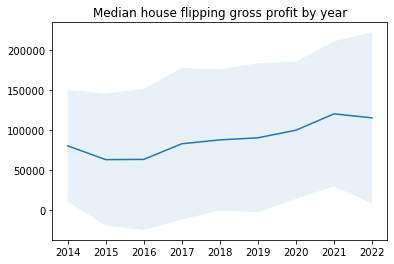

In [148]:
import matplotlib.pyplot as plt
import plotly_express as px

plt.plot('year', 'median', data=flip_yrs)
plt.fill_between(flip_yrs['year'],flip_yrs['median']-flip_yrs['std'],flip_yrs['median']+flip_yrs['std'],alpha=.1)

plt.title('Median house flipping gross profit by year')
plt.show()

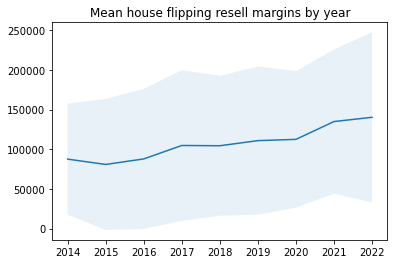

In [151]:
import matplotlib.pyplot as plt
import plotly_express as px

plt.plot('year', 'mean', data=flip_yrs)
plt.fill_between(flip_yrs['year'],flip_yrs['mean']-flip_yrs['std'],flip_yrs['mean']+flip_yrs['std'],alpha=.1)

plt.title('Mean house flipping resell margins by year')
plt.show()

<AxesSubplot:>

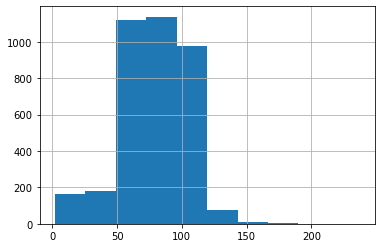

In [150]:
flips['age'].hist()

In [166]:
flips.columns

Index(['Parcel_ID', 'Grantor_x', 'Grantee_x', 'sale_x', 'NBHDno_x',
       'district_number_x', 'Transfer_date_x', 'Consideration_x',
       'TransferComment_x', 'YrBuilt_x', 'FinSize_x', 'Grantor_y', 'Grantee_y',
       'sale_y', 'NBHDno_y', 'district_number_y', 'Transfer_date_y',
       'Consideration_y', 'TransferComment_y', 'YrBuilt_y', 'FinSize_y',
       'hold_time', 'price_diff', 'size_diff', 'year', 'age'],
      dtype='object')

In [219]:
# plus neighborhood? district probably better
flips['council'] = flips['district_number_x'].astype('str').str[:1]
fyn = flips.groupby(['year','council']).agg({'price_diff':['mean','median','std']}).reset_index()
fyn.columns = ['year','dist','mean','median','std']

<ipython-input-219-8951044c4afc>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [220]:
px.line(fyn, x='year', y='median', color='dist',
       title='Richmond VA - house flipping profit',
       labels={
                     "year": "Year",
                     "median": "Median gross profit",
                     "dist": "Council district"
                 })


In [225]:
# try with roi
flips['council'] = flips['district_number_x'].astype('str').str[:1]
fynr = flips.groupby(['year','council']).agg({'roi':['mean','median','std']}).reset_index()
fynr.columns = ['year','dist','mean','median','std']
px.line(fynr, x='year', y='median', color='dist',
       title='Richmond VA - house flipping ROI',
       labels={
                     "year": "Year",
                     "median": "Median gross ROI",
                     "dist": "Council district"
                 })

<ipython-input-225-fa3993cdd9ce>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [226]:
# Found and removed a big outlier this way
px.line(fynr, x='year', y='mean', color='dist',
       title='Richmond VA - house flipping',
       labels={
                     "year": "Year",
                     "median": "Mean gross ROI",
                     "dist": "Council district"
                 })

In [190]:
# try with count
flips['council'] = flips['district_number_x'].astype('str').str[:1]
fynr = flips.groupby(['year','council']).agg({'roi':['mean','median','std','count']}).reset_index()
fynr.columns = ['year','dist','mean','median','std','count']
px.line(fynr, x='year', y='count', color='dist',
       title='Richmond VA - house flipping count',
       labels={
                     "year": "Year",
                     "median": "Number of flips sold",
                     "dist": "Council district"
                 })

In [204]:
flips.to_csv('data/flips.csv')